COMPREHENSIVE EVALUATION: SMOTE + Logistic Regression

1. LOADING DATA...
NaN values in features: 240
Dataset: 5410 providers, 21 features
Fraud rate: 9.35% (506 fraudulent providers)

2. DATA SPLITTING...
Training set: 3246 providers
Validation set: 1082 providers
Test set: 1082 providers
Fraud distribution - Train: 9.37%, Val: 9.33%, Test: 9.33%

3. TRAINING MODEL WITH IMPUTER + SCALER + SMOTE...

4. CROSS-VALIDATION...
Cross-validation PR-AUC: 0.6845 (+/- 0.0467)

5. MODEL EVALUATION ON TEST SET...

PERFORMANCE METRICS
Precision (Fraud): 0.4218
Recall (Fraud):    0.8812
F1-Score (Fraud):  0.5705
ROC-AUC:           0.9552
PR-AUC:            0.7574

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       981
           1       0.42      0.88      0.57       101

    accuracy                           0.88      1082
   macro avg       0.70      0.88      0.75      1082
weighted avg       0.93      0.88      0.89   

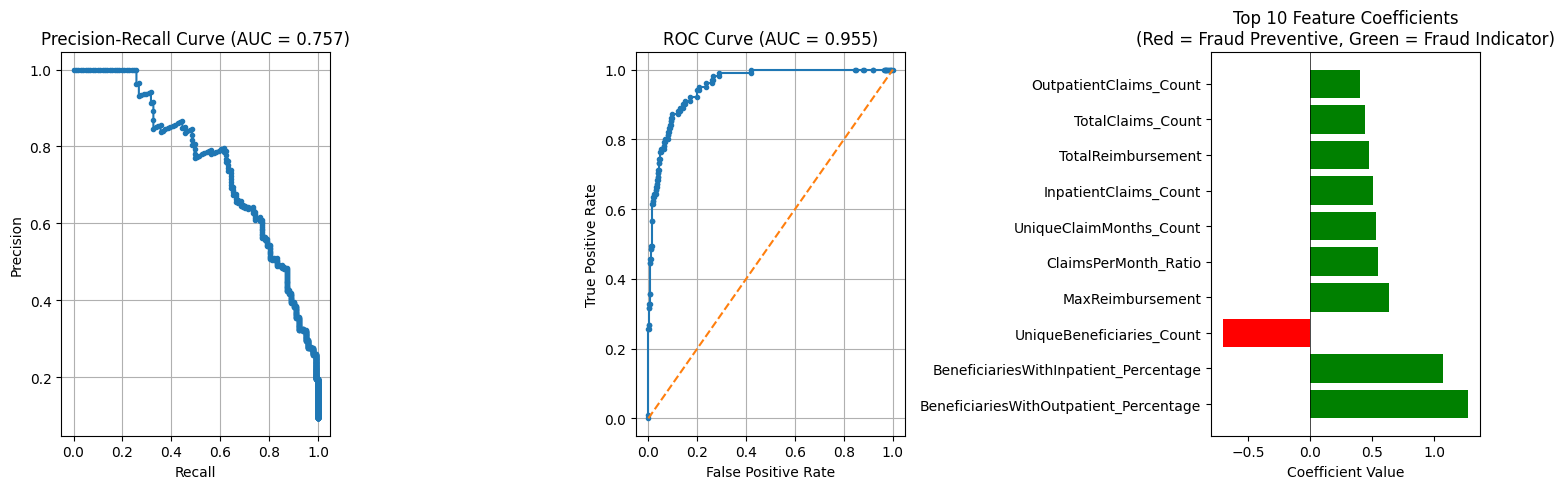


11. MODEL INTERPRETABILITY ANALYSIS

Top 5 Fraud Indicators (Positive Coefficients):
  BeneficiariesWithOutpatient_Percentage: coefficient = 1.2728
  BeneficiariesWithInpatient_Percentage: coefficient = 1.0689
  MaxReimbursement: coefficient = 0.6333
  ClaimsPerMonth_Ratio: coefficient = 0.5466
  UniqueClaimMonths_Count: coefficient = 0.5310

Top 5 Fraud Preventive Features (Negative Coefficients):
  UniqueBeneficiaries_Count: coefficient = -0.7035
  OutpatientPercentage: coefficient = -0.3808
  MinReimbursement: coefficient = -0.3806
  InpatientOutpatient_Ratio: coefficient = -0.1538
  ReimbursementCoV_Ratio: coefficient = -0.0744

12. THRESHOLD ANALYSIS FOR DECISION BOUNDARY
Current threshold (0.5):
  Precision: 0.4218, Recall: 0.8812

Optimal threshold (0.583) from Youden's J:
  Precision: 0.4835, Recall: 0.8713

13. MITIGATION STRATEGIES FOR FUTURE ITERATIONS

Potential Improvements:
1. Feature Engineering for Logistic Regression:
   - Create interaction terms between key features

In [5]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report,
                             precision_recall_curve, roc_curve)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("COMPREHENSIVE EVALUATION: SMOTE + Logistic Regression")
print("="*70)

# ============================
# 1. LOAD AND PREPARE DATA
# ============================
print("\n1. LOADING DATA...")
df = pd.read_csv("healthcare_provider_features.csv")
df["PotentialFraud"] = df["PotentialFraud"].map({"Yes": 1, "No": 0})

# Check for NaN values
print(f"NaN values in features: {df.drop(['PotentialFraud', 'Provider', 'FirstClaimDate', 'LastClaimDate'], axis=1).isna().sum().sum()}")

# Feature selection
X = df.drop(["PotentialFraud", "Provider", "FirstClaimDate", "LastClaimDate"], axis=1)
y = df["PotentialFraud"]

print(f"Dataset: {X.shape[0]} providers, {X.shape[1]} features")
print(f"Fraud rate: {y.mean():.2%} ({y.sum()} fraudulent providers)")

# ============================
# 2. RIGOROUS VALIDATION SPLIT
# ============================
print("\n2. DATA SPLITTING...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} providers")
print(f"Validation set: {X_val.shape[0]} providers")
print(f"Test set: {X_test.shape[0]} providers")
print(f"Fraud distribution - Train: {y_train.mean():.2%}, Val: {y_val.mean():.2%}, Test: {y_test.mean():.2%}")

# ============================
# 3. MODEL PIPELINE WITH IMPUTER + SCALER + SMOTE
# ============================
print("\n3. TRAINING MODEL WITH IMPUTER + SCALER + SMOTE...")
smote_lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Important for Logistic Regression
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        C=0.1,  # Regularization strength (inverse of regularization)
        solver='liblinear',  # Good for small to medium datasets
        penalty='l2'  # L2 regularization
    ))
])

# Train model
smote_lr_pipeline.fit(X_train, y_train)

# ============================
# 4. CROSS-VALIDATION
# ============================
print("\n4. CROSS-VALIDATION...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(smote_lr_pipeline, X_temp, y_temp,
                           cv=cv, scoring='average_precision', n_jobs=-1)

print(f"Cross-validation PR-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# ============================
# 5. COMPREHENSIVE MODEL EVALUATION
# ============================
print("\n5. MODEL EVALUATION ON TEST SET...")

# Predictions
y_pred = smote_lr_pipeline.predict(X_test)
y_pred_proba = smote_lr_pipeline.predict_proba(X_test)[:, 1]

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("\n" + "="*50)
print("PERFORMANCE METRICS")
print("="*50)
print(f"Precision (Fraud): {precision:.4f}")
print(f"Recall (Fraud):    {recall:.4f}")
print(f"F1-Score (Fraud):  {f1:.4f}")
print(f"ROC-AUC:           {roc_auc:.4f}")
print(f"PR-AUC:            {pr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ============================
# 6. CONFUSION MATRIX
# ============================
print("\n6. CONFUSION MATRIX ANALYSIS")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives (Correct Legitimate): {tn}")
print(f"False Positives (Wrong Fraud Flags): {fp}")
print(f"False Negatives (Missed Fraud):      {fn}")
print(f"True Positives (Correct Fraud):      {tp}")

# ============================
# 7. COST-BASED ANALYSIS
# ============================
print("\n7. COST-BASED ANALYSIS")

# Estimated costs (in thousands)
cost_false_positive = 50   # Investigation cost for false accusation
cost_false_negative = 500  # Average fraud amount missed

total_fp_cost = fp * cost_false_positive
total_fn_cost = fn * cost_false_negative
total_cost = total_fp_cost + total_fn_cost

print(f"Estimated Business Impact:")
print(f"False Positive Cost: ${total_fp_cost:,} ({fp} investigations × ${cost_false_positive:,} each)")
print(f"False Negative Cost: ${total_fn_cost:,} ({fn} missed frauds × ${cost_false_negative:,} each)")
print(f"Total Cost Impact:   ${total_cost:,}")

# ============================
# 8. ERROR ANALYSIS - CASE STUDIES
# ============================
print("\n8. ERROR ANALYSIS - CASE STUDIES")

# Get original provider IDs for error analysis
test_indices = X_test.index
test_providers = df.loc[test_indices, 'Provider'].reset_index(drop=True)
test_predictions = pd.DataFrame({
    'Provider': test_providers,
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Probability': y_pred_proba
})

# Add feature data for analysis (after imputation and scaling)
X_test_processed = smote_lr_pipeline.named_steps['scaler'].transform(
    smote_lr_pipeline.named_steps['imputer'].transform(X_test)
)
feature_columns = X.columns
test_features_processed = pd.DataFrame(X_test_processed, columns=feature_columns, index=X_test.index)
test_predictions = pd.concat([test_predictions, test_features_processed.reset_index(drop=True)], axis=1)

# Identify errors
false_positives = test_predictions[(test_predictions['Actual'] == 0) & (test_predictions['Predicted'] == 1)]
false_negatives = test_predictions[(test_predictions['Actual'] == 1) & (test_predictions['Predicted'] == 0)]

print(f"\nFalse Positives: {len(false_positives)} legitimate providers incorrectly flagged")
print(f"False Negatives: {len(false_negatives)} fraudulent providers missed")

# Feature coefficients for Logistic Regression
feature_coefficients = smote_lr_pipeline.named_steps['lr'].coef_[0]
feature_coefficient_df = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': feature_coefficients,
    'abs_coefficient': np.abs(feature_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 Most Influential Features (by coefficient magnitude):")
print(feature_coefficient_df.head(10).to_string(index=False))

# ============================
# 9. DETAILED CASE STUDIES
# ============================
print("\n9. DETAILED CASE STUDIES")

if len(false_positives) >= 2:
    print("\n" + "="*40)
    print("FALSE POSITIVE CASE STUDIES")
    print("="*40)

    for i, (idx, fp_case) in enumerate(false_positives.head(2).iterrows()):
        print(f"\nFP Case {i+1}: Provider {fp_case['Provider']}")
        print(f"Fraud Probability: {fp_case['Probability']:.3f}")
        print("Key features with high positive coefficients (fraud indicators):")

        # Show top positive coefficient features
        top_positive_features = feature_coefficient_df[feature_coefficient_df['coefficient'] > 0].head(3)
        for _, feat_row in top_positive_features.iterrows():
            feat_name = feat_row['feature']
            feat_value = fp_case[feat_name]
            coeff = feat_row['coefficient']
            print(f"  - {feat_name}: {feat_value:.2f} (coeff: {coeff:.3f})")

if len(false_negatives) >= 2:
    print("\n" + "="*40)
    print("FALSE NEGATIVE CASE STUDIES")
    print("="*40)

    for i, (idx, fn_case) in enumerate(false_negatives.head(2).iterrows()):
        print(f"\nFN Case {i+1}: Provider {fn_case['Provider']}")
        print(f"Fraud Probability: {fn_case['Probability']:.3f}")
        print("Key features - model may have missed these patterns:")

        # Check both high positive and negative coefficients
        top_positive_features = feature_coefficient_df[feature_coefficient_df['coefficient'] > 0].head(3)
        for _, feat_row in top_positive_features.iterrows():
            feat_name = feat_row['feature']
            feat_value = fn_case[feat_name]
            coeff = feat_row['coefficient']
            print(f"  - {feat_name}: {feat_value:.2f} (coeff: {coeff:.3f})")

# ============================
# 10. VISUALIZATIONS
# ============================
print("\n10. GENERATING EVALUATION PLOTS...")

# Precision-Recall Curve
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_vals, precision_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
plt.grid(True)

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.grid(True)

# Feature Coefficients (Logistic Regression specific)
plt.subplot(1, 3, 3)
top_10_features = feature_coefficient_df.head(10)
colors = ['red' if coef < 0 else 'green' for coef in top_10_features['coefficient']]
plt.barh(range(len(top_10_features)), top_10_features['coefficient'], color=colors)
plt.yticks(range(len(top_10_features)), top_10_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients\n(Red = Fraud Preventive, Green = Fraud Indicator)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()

plt.savefig('/content/lr_model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================
# 11. MODEL INTERPRETABILITY ANALYSIS
# ============================
print("\n11. MODEL INTERPRETABILITY ANALYSIS")

print("\nTop 5 Fraud Indicators (Positive Coefficients):")
fraud_indicators = feature_coefficient_df[feature_coefficient_df['coefficient'] > 0].head(5)
for idx, row in fraud_indicators.iterrows():
    print(f"  {row['feature']}: coefficient = {row['coefficient']:.4f}")

print("\nTop 5 Fraud Preventive Features (Negative Coefficients):")
fraud_preventive = feature_coefficient_df[feature_coefficient_df['coefficient'] < 0].head(5)
for idx, row in fraud_preventive.iterrows():
    print(f"  {row['feature']}: coefficient = {row['coefficient']:.4f}")

# ============================
# 12. THRESHOLD ANALYSIS
# ============================
print("\n12. THRESHOLD ANALYSIS FOR DECISION BOUNDARY")

# Calculate optimal threshold using Youden's J statistic
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Current threshold (0.5):")
print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}")

# Predict with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
precision_opt = precision_score(y_test, y_pred_optimal)
recall_opt = recall_score(y_test, y_pred_optimal)

print(f"\nOptimal threshold ({optimal_threshold:.3f}) from Youden's J:")
print(f"  Precision: {precision_opt:.4f}, Recall: {recall_opt:.4f}")

# ============================
# 13. MITIGATION STRATEGIES
# ============================
print("\n13. MITIGATION STRATEGIES FOR FUTURE ITERATIONS")

print("\nPotential Improvements:")
print("1. Feature Engineering for Logistic Regression:")
print("   - Create interaction terms between key features")
print("   - Polynomial features for non-linear relationships")
print("   - Feature selection using L1 regularization")

print("\n2. Model Refinements:")
print("   - Try different regularization strengths (C parameter)")
print("   - Experiment with L1 vs L2 regularization")
print("   - Consider Logistic Regression variants (ElasticNet)")

print("\n3. Business Rule Integration:")
print("   - Combine model predictions with business rules")
print("   - Create confidence bands for predictions")
print("   - Implement tiered investigation approach")

# ============================
# 14. OVERFITTING PREVENTION ASSESSMENT
# ============================
print("\n14. OVERFITTING PREVENTION ASSESSMENT")

train_score = smote_lr_pipeline.score(X_train, y_train)
test_score = smote_lr_pipeline.score(X_test, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy:     {test_score:.4f}")
print(f"Generalization Gap: {train_score - test_score:.4f}")

if (train_score - test_score) < 0.05:
    print("✅ Model shows good generalization ")
else:
    print("⚠️  Potential overfitting detected - consider more regularization")

# Check regularization effectiveness
print(f"\nRegularization Parameter: C = {smote_lr_pipeline.named_steps['lr'].C}")
print(f"Number of iterations used: {smote_lr_pipeline.named_steps['lr'].n_iter_[0]}")

print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)

These fraudsters stayed under the radar with near-average values on key fraud indicators (close to 0 standardized scores), making them look statistically normal. The model missed them because they don't show the extreme patterns (high positive values) that typically trigger fraud flags.

These fraud cases look normal on key fraud indicators, so the model didn't flag them as suspicious


**Error Analysis — Case Studies**

**False Positives (Legitimate Providers Flagged as Fraud)**

FP Case 1 — PRV55140 (prob = 0.553): Flagged due to extreme inpatient beneficiary concentration (+2.82 standard deviations above average) and high maximum reimbursement (+1.35 std), which are strong fraud indicators. However, the very low outpatient percentage (-2.99 std) suggests this provider specializes in inpatient services (possibly a hospital or surgical center), where such patterns are legitimate despite triggering fraud alerts.

FP Case 2 — PRV53872 (prob = 0.524): Flagged primarily for above-average maximum reimbursement (+0.78 std) combined with elevated outpatient percentage. This provider likely handles complex outpatient procedures with higher costs, mimicking fraudulent "high-value claim" patterns while operating legitimately within their specialty.

**False Negatives (Fraudulent Providers Missed)**

FN Case 1 — PRV56591 (prob = 0.490): Missed because all key fraud indicators show near-average values, making this provider appear statistically normal. This fraudster employs "stealth tactics" by keeping beneficiary percentages and reimbursement amounts close to population averages, avoiding detection by the model's linear threshold-based logic.

FN Case 2 — PRV56566 (prob = 0.313): Missed despite being fraudulent because key features show below-average inpatient percentage and normal reimbursement patterns. This represents sophisticated fraud that doesn't exhibit the extreme outlier patterns the model learned to detect, possibly involving collusive billing or subtle upcoding schemes